In [1]:
import numpy as np
import networkx as nx
import random
from networkx.generators.random_graphs import erdos_renyi_graph
from tools import *

# Network parameters

In [2]:
N=20 #router number
m=3 #shortest path number
sim_num=1
memsize=10000 #in mb
min_vert_degree=1 #min vertex degree
router_rate_reduction=[0.2,0.5] #router max data rate reduction range in comparison with the maximum demand from the links
router_delay_coefficient=8 #defines delay time while the package passing through router
link_delay_coefficient=4 #defines delay time while the package passing through link

file_name_full_graph='full_graph_{}_{}.txt'.format(N,sim_num)
file_network='network_{}_{}.txt'.format(N,sim_num)

file_name_full_graph_optimal_path='full_graph_and_prime_shortest_path_{}_{}.txt'.format(N,sim_num)
file_name_cluster_graph='cluster_graph_{}_{}.txt'.format(N,sim_num)
file_name_shortest_path='full_graph_shortest_path_{}_{}.txt'.format(N,sim_num)
file_name_prime_routers_shortest_path='prime_graph_shortest_path_{}_{}.txt'.format(N,sim_num)
file_name_prime_graph='prime_graph_{}_{}.txt'.format(N,sim_num)

In [3]:
Umax=[100000, 150000, 200000] #link maximum data rate
prob=[0.5,0.3,0.2] #probabilities of link maximum data rates

In [4]:
#routers_load=0.1/router_delay_coefficient #low load on the network
routers_load=0.3/router_delay_coefficient#medium load on the network
#routers_load=0.5/router_delay_coefficient#high load on the network

sigma_routers=0.2/router_delay_coefficient

In [33]:
routers_load

0.0375

# Graph generation

In [5]:
p=32*2/(20*19) #ARPANET's edge probability

In [6]:
p

0.16842105263157894

In [7]:
while True: #generating connected graph
    g = erdos_renyi_graph(N, p)
    d=dict(g.degree)
    
    min_degree=min(d.items(), key=lambda x: x[1])[1]
    
    if min_degree>=min_vert_degree and nx.is_connected(g):
        break
    

In [8]:
print('vertices', g.nodes) 

vertices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [9]:
print('edges', g.edges) 

edges [(0, 11), (0, 12), (0, 16), (1, 15), (1, 16), (2, 13), (2, 18), (3, 4), (3, 8), (3, 9), (4, 12), (4, 15), (5, 6), (6, 8), (6, 10), (6, 13), (7, 10), (7, 11), (7, 17), (7, 18), (8, 17), (10, 15), (11, 13), (11, 19), (12, 18), (12, 19), (13, 15), (13, 19), (14, 17), (16, 18)]


In [10]:
d=dict(g.degree)
    
min_degree=min(d.items(), key=lambda x: x[1])

print('min vertex degree', min_degree[1])

min vertex degree 1


## Generating network 

In [11]:
U={} 

for e in g.edges: 
    x,y=e
    U[e]=np.random.choice(Umax, p=prob) #generating max link data rate
    U[(y,x)]=U[e]

In [12]:
print('link capacities', U)

link capacities {(0, 11): 100000, (11, 0): 100000, (0, 12): 200000, (12, 0): 200000, (0, 16): 100000, (16, 0): 100000, (1, 15): 100000, (15, 1): 100000, (1, 16): 150000, (16, 1): 150000, (2, 13): 100000, (13, 2): 100000, (2, 18): 150000, (18, 2): 150000, (3, 4): 150000, (4, 3): 150000, (3, 8): 100000, (8, 3): 100000, (3, 9): 100000, (9, 3): 100000, (4, 12): 100000, (12, 4): 100000, (4, 15): 100000, (15, 4): 100000, (5, 6): 150000, (6, 5): 150000, (6, 8): 150000, (8, 6): 150000, (6, 10): 150000, (10, 6): 150000, (6, 13): 100000, (13, 6): 100000, (7, 10): 100000, (10, 7): 100000, (7, 11): 150000, (11, 7): 150000, (7, 17): 100000, (17, 7): 100000, (7, 18): 100000, (18, 7): 100000, (8, 17): 150000, (17, 8): 150000, (10, 15): 100000, (15, 10): 100000, (11, 13): 150000, (13, 11): 150000, (11, 19): 200000, (19, 11): 200000, (12, 18): 200000, (18, 12): 200000, (12, 19): 100000, (19, 12): 100000, (13, 15): 100000, (15, 13): 100000, (13, 19): 150000, (19, 13): 150000, (14, 17): 100000, (17, 14):

In [13]:
router_data_rate=[0]*N

for e in g.edges: 
    x,y=e
    router_data_rate[x]+=U[(y,x)]
    router_data_rate[y]+=U[(x,y)]
    

reduction=np.random.uniform(low=router_rate_reduction[0], high=router_rate_reduction[1], size=(N,))

router_data_rate*=reduction

router_data_rate=np.maximum(1, router_data_rate//10000)*10000 #making them a multiple of 10000

In [14]:
print('router data rates', router_data_rate)

router data rates [190000.  80000.  80000.  70000. 160000.  40000. 170000. 150000.  80000.
  40000. 150000. 230000. 240000. 150000.  40000. 140000. 160000. 130000.
 170000. 120000.]


In [15]:
weight={}
const=1e6

for e in g.edges: 
    x,y=e
    weight[(x,y)]=link_delay_coefficient/U[(x,y)] + router_delay_coefficient/router_data_rate[y]   
    weight[(y,x)]=link_delay_coefficient/U[(y,x)] + router_delay_coefficient/router_data_rate[x] 

In [16]:
weight

{(0, 11): 7.478260869565217e-05,
 (11, 0): 8.210526315789474e-05,
 (0, 12): 5.333333333333333e-05,
 (12, 0): 6.210526315789474e-05,
 (0, 16): 9e-05,
 (16, 0): 8.210526315789474e-05,
 (1, 15): 9.714285714285714e-05,
 (15, 1): 0.00014000000000000001,
 (1, 16): 7.666666666666667e-05,
 (16, 1): 0.00012666666666666666,
 (2, 13): 9.333333333333334e-05,
 (13, 2): 0.00014000000000000001,
 (2, 18): 7.372549019607843e-05,
 (18, 2): 0.00012666666666666666,
 (3, 4): 7.666666666666667e-05,
 (4, 3): 0.00014095238095238096,
 (3, 8): 0.00014000000000000001,
 (8, 3): 0.00015428571428571428,
 (3, 9): 0.00024,
 (9, 3): 0.00015428571428571428,
 (4, 12): 7.333333333333334e-05,
 (12, 4): 9e-05,
 (4, 15): 9.714285714285714e-05,
 (15, 4): 9e-05,
 (5, 6): 7.372549019607843e-05,
 (6, 5): 0.00022666666666666668,
 (6, 8): 0.00012666666666666666,
 (8, 6): 7.372549019607843e-05,
 (6, 10): 7.999999999999999e-05,
 (10, 6): 7.372549019607843e-05,
 (6, 13): 9.333333333333334e-05,
 (13, 6): 8.705882352941177e-05,
 (7, 1

# Generating user's demand 

In [17]:
s = np.random.normal(1, 2, 1000)

In [18]:
s

array([-1.42908786e+00,  1.82544921e+00,  3.24470299e+00, -5.12700908e-01,
        4.79506433e+00,  5.49781070e+00,  8.67737470e-01,  5.35009741e+00,
        3.60493384e-01,  6.97635190e-01, -6.80767683e-01,  1.19528628e+00,
       -5.44051254e-01, -4.21024112e-01, -1.37489913e+00, -5.67758341e-01,
        3.72480290e+00, -1.49416399e+00, -7.00282814e-01,  6.54786565e-01,
        8.63435953e-01, -7.00513992e-01,  1.71729876e+00,  4.39531742e+00,
        4.34151936e-01, -2.28385829e-01,  1.52827035e-01,  1.61408749e+00,
       -6.72245479e-01,  2.58540029e+00,  2.09958989e+00,  6.36132179e-01,
        2.26634591e+00, -2.16887101e-01,  1.46644431e+00, -8.45544378e-01,
       -3.98304979e-01, -9.40132302e-02,  4.08332395e+00, -3.14415845e+00,
        9.78245306e-01, -5.29304343e-01,  2.61127575e+00, -1.12595332e+00,
       -3.03002856e+00,  1.39232868e+00, -8.30037283e-01,  1.35972279e+00,
        1.21608980e+00,  3.85805838e+00,  1.69292844e+00,  4.60845928e+00,
        1.83939130e+00,  

In [19]:
routers_load

0.0375

In [20]:
sigma_routers

0.025

In [38]:
router_data_rate/router_delay_coefficient

array([23750., 10000., 10000.,  8750., 20000.,  5000., 21250., 18750.,
       10000.,  5000., 18750., 28750., 30000., 18750.,  5000., 17500.,
       20000., 16250., 21250., 15000.])

In [40]:
routers_load

0.0375

In [41]:
(N-1)

19

In [43]:
D=np.zeros((N+1,N+1))

for i in range(1,N+1):
    for j in range(1,N+1):
        av_router_data_rate=(router_data_rate[i-1]+router_data_rate[j-1])/2
        #print('av_router_data_rate',av_router_data_rate)
        
        mean=routers_load*av_router_data_rate/(N-1)
        #print('mean',mean)
        sigma=sigma_routers*av_router_data_rate/N
        
        #print('mean,sigma',mean,sigma)
        D[i][j]=np.random.normal(mean,sigma)
        D[i][j]=min(D[i][j], routers_load*av_router_data_rate/(N-1)*0.7)
        #print('mean,sigma',mean,sigma)
        D[i][j]=max(D[i][j], routers_load*av_router_data_rate/(N-1)*0.1)
        #print('D[i][j]',D[i][j])

#average_user_demand=np.maximum(np.minimum(np.random.normal(mean,sigma,N),router_data_rate/router_delay_coefficient*0.6), router_data_rate/router_delay_coefficient*0.2)

In [44]:
mean

236.8421052631579

In [45]:
D[1]

array([  0.        , 262.5       , 186.51315789, 186.51315789,
       179.60526316,  81.48424551, 158.88157895, 248.68421053,
       120.08455604, 186.51315789, 128.75212719, 234.86842105,
       290.13157895, 188.7326971 ,  33.55263158, 141.79973279,
       117.91743356, 241.77631579,  31.57894737,  77.16426128,
        61.05288849])

# Saving graph to a file

In [25]:
WriteGraph(file_name_full_graph, N, g.edges, weight)

# Saving network to file

In [26]:
WriteNetwork(file_network, N, D, g.edges, U, router_data_rate)

# Drawing the network

In [27]:
mapping={}

for i in range(N):
    mapping[i]=i+1 #shifting labels by one so they start from 1

In [28]:
g = nx.relabel_nodes(g, mapping, copy=False)

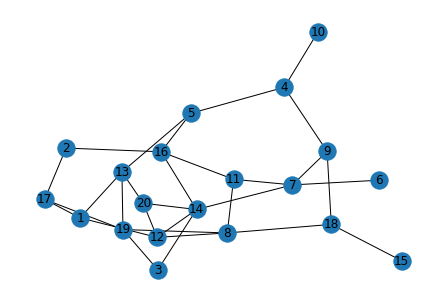

In [29]:
nx.draw(g, with_labels=True)